In [1]:
import pandas as pd
import glob
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pyBigWig
source='data/source/'

In [2]:
h=pd.read_pickle('data/h.pkl')
h=h[h['bl']==0]
print(h.shape)
#h['ez']=h[['ez1','ez2']].min(1)
#h=h.sort_values('ez',ascending=False)

(37919, 10)


In [3]:
h['suz']=h.suz/h.suz.max()
h['ez1']=h.ez1/h.ez1.max()
h['ez2']=h.ez2/h.ez2.max()
h['ez']=h[['ez1','ez2']].mean(1)
h['prc']=h[['ez','suz']].mean(1)

In [4]:
hz=h.sort_values('prc',ascending=False).head(1000)
#hz=hz[hz.d>3500]
len(hz)

1000

In [29]:
hz[hz.ch=='chr7'].head(1)

,ch,b,e,d,r,rd,suz,ez1,ez2,bl,ez,prc
34815,chr7,137309054,137315812,6758,"{137310208, 137314313, 137310232, 137314328, 1...",475,0.714282,0.647287,0.75,0,0.698643,0.706463


In [27]:
hg=h.groupby('ch')['r'].apply(list)
hg=hg.apply(lambda x:set.union(*x))

In [29]:
fs=glob.glob('data/meth/GSE120137/l/*.txt')
def get_meth(fs):
    fs.sort()
    print(len(fs))
    n=7
    dfs=[]
    for sn in fs:
        name=sn.split('SH')[1][:3]
        print(name,end=',')
        df=pd.read_table(sn,engine='c',sep=' ',header=None,nrows=10**n)
        df=df[df[0].isin(hg.index)]
        df['hmr']=df.apply(lambda x:x[2]-1 in hg[x[0]],axis=1)
        df=df[df['hmr']][[0,2,5]]
        df.index=df[0].str[3:5]+'_'+(df[2]-1).astype(str)
        #h[name]=h.apply(lambda x: bw.stats(x['ch'],x['b'],x['e'],'mean',exact=True)[0],axis=1)
        dfs.append(df[5].rename(name))

In [54]:
hzs=[]
for i,rr in hz.iterrows():
    for r in list(rr['r']):
        hzs.append(rr['ch'][3:5]+'_'+str(r))
len(hzs)

177715

In [14]:
rrbs='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE120nnn/GSE120137/matrix/GSE120137-GPL21103_series_matrix.txt.gz'
age=pd.read_table(rrbs,skiprows=31).T
age=age.drop('!Sample_title')
age['age']=age[10].str[5:].str[:-2].astype(float)
age['id']=age.index.str[-3:]
ps={}

In [86]:
age['age']=age['age'].astype(int).astype(str)+' months'

In [76]:
for c in ['m','a','k','l','u','b']:
    fs=glob.glob('data/meth/GSE120137/'+c+'/csv/*.csv')
    dfs=[]
    for f in fs:
        print ('',end=',')
        df=pd.read_csv(f,index_col=0)
        df=df[df.index.isin(hzs)]
        dfs.append(df)
    df=dfs[0].merge(dfs[1],left_index=True,right_index=True,how='outer')
    for i in range(2,len(dfs)):
        print(i,end=',')
        df=df.merge(dfs[i],left_index=True,right_index=True,how='outer')
    df.shape
    p=df.mean()
    p=p.rename('DNAm')
    ps[c]=age[['id','age']].drop_duplicates().merge(p,left_on='id',right_index=True)    

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,

In [89]:
ps['l']['Tissue']='Liver'
ps['b']['Tissue']='Blood'
ps['b']=ps['b'][ps['b'].age.isin([2,10,20])]

In [90]:
ps['m']['Tissue']='Muscle'
ps['a']['Tissue']='Adipose'
ps['k']['Tissue']='Kidney'
ps['u']['Tissue']='Lung'

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
ax=sns.barplot(data=pd.concat(ps),x='Tissue',y='DNAm',hue='age'
            ,order=['Adipose','Kidney','Muscle','Lung','Liver','Blood'],palette=['g','orange','r']);
ax.set(title='DNAm at PRC2 binding regions (mice)',ylabel='Average DNAm');

In [228]:
hz=h.sort_values('prc',ascending=False).head(1000)
print(len(hz))

1000


In [229]:
fs=['SRR44738'+str(i) for i in range(55,71)]

In [230]:
for sn in fs:
    print(sn,end=',')
    path='data/meth/l/'+sn+'.bw'
    bw=pyBigWig.open(path)
    hz[sn]=hz.apply(lambda x: bw.stats(x['ch'],x['b'],x['e'],'mean',exact=True)[0],axis=1)

SRR4473855,SRR4473856,SRR4473857,SRR4473858,SRR4473859,SRR4473860,SRR4473861,SRR4473862,SRR4473863,SRR4473864,SRR4473865,SRR4473866,SRR4473867,SRR4473868,SRR4473869,SRR4473870,

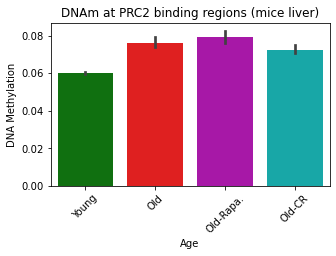

In [231]:
p=pd.DataFrame(hz[[f for f in fs]].mean())
p['Age']=4*['Young']+4*['Old']+4*['Old-Rapa.']+4*['Old-CR']
#p.columns=['Average DNAm','Passage']#,'Condition','Individual']
fig, ax = plt.subplots(figsize=(5,3))
ax=sns.barplot(data=p,x='Age',y=0,palette=['g','r','m','c'])
ax.set( ylabel='DNA Methylation',title='DNAm at PRC2 binding regions (mice liver)')
ax.tick_params(axis='x', rotation=45)

In [ ]:
df=pd.read_csv('../../aging/mice/data/blood.csv',engine='c',index_col=0)
age=pd.read_csv('../../aging/mice/data/blood_age.csv',index_col=0)

In [ ]:
print(df.shape,len(age))

(1940728, 195) 195


In [96]:
hzg=hz.groupby('ch')['r'].apply(list)
hzg=hzg.apply(lambda x:set.union(*x)) 
hzs=[]
for i,r in hz.iterrows():
    for rr in r['r']:
        hzs.append((r['ch'],rr+1))
hzs=pd.DataFrame(hzs)     
hzs.index=hzs[0].str[3:5]+'_'+(hzs[1]-1).astype(str)
len(hzs)

177715

In [101]:
def f(x):
    return int(x.name.split('_')[1])-1 in hzg[x.name.split('_')[0]]
df.index='chr'+df.index
dfhz=df[df.apply(lambda x:f(x),axis=1)]
dfhz.columns=dfhz.columns.astype(int)
len(dfhz)

60901

In [116]:
age=age.merge(dfhz.mean().rename('m'),left_index=True,right_index=True)
age.columns=['','Age (months)','Avergae DNAm']
age.head(1)

,,Age (months),Avergae DNAm
2132712,diet: standard,0.67,4.543045


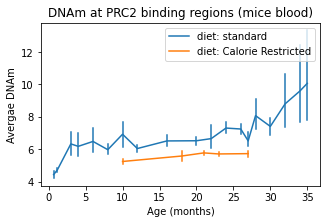

In [121]:
fig, ax = plt.subplots(figsize=(5,3))
ax=sns.lineplot(data=age,x='Age (months)',y='Avergae DNAm',hue='',err_style='bars')
ax.set(title='DNAm at PRC2 binding regions (mice blood)');

In [126]:
hz[['ch','b','e']].to_csv('data/h10.bed',header=None,index=None,sep='\t')

In [6]:
h9=pd.read_table('data/h9.bed',header=None)
h9.head(1)

,0,1,2
0,chr8,87307571,87310845


In [36]:
fs=['GSM2839854_MEF','GSM2839855_d3_ineff','GSM2839856_d3_eff','GSM2839857_d6_ineff','GSM2839858_d6_eff','GSM1027571_DNA_CpG_coverage_E14_serum_LIF']
for sn in fs:
    print(sn,end=',')
    path='data/meth/rep/'+sn+'.bw'
    bw=pyBigWig.open(path)
    h9[sn]=h9.apply(lambda x: bw.stats(x[0],x[1],x[2],'mean',exact=True)[0],axis=1)
for sn in fs:
    h9[sn]=h9[sn]/1000    

GSM2839854_MEF,GSM2839855_d3_ineff,GSM2839856_d3_eff,GSM2839857_d6_ineff,GSM2839858_d6_eff,GSM1027571_DNA_CpG_coverage_E14_serum_LIF,

In [56]:
h9=h9[[0]+fs]

In [62]:
h9.columns=[0]+[c[11:] for c in h9.columns[1:]]

In [73]:
h9=h9.rename({'DNA_CpG_coverage_E14_serum_LIF':'ESC'},axis=1)

In [104]:
pl=h9.melt(0)

In [105]:
pl['chn']=pl[0].str[3:].astype(int)
pl=pl.sort_values('chn').drop('chn',axis=1)

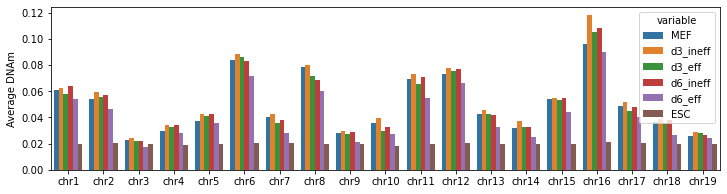

In [108]:
fig, ax = plt.subplots(figsize=(12,3))
ax=sns.barplot(data=pl,x=0,hue='variable',y='value',ci=0,hue_order=h9.columns[1:]);
ax.set(xlabel='',ylabel='Average DNAm');

In [99]:
pl=h9

In [100]:
pl.melt().head(1)

,variable,value
0,0,chr8


/local/scratch/moqri/slrmtmp.30994955/ipykernel_16449/1044725566.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  h9.mean().plot(kind='bar',ax=ax)


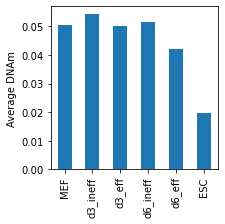

In [102]:
fig, ax = plt.subplots(figsize=(3,3))
h9.mean().plot(kind='bar',ax=ax)
ax.set(xlabel='',ylabel='Average DNAm');

In [5]:
fs=['GSM2794005','GSM2794006','GSM2794007','GSM2794008','GSM2794009','GSM2794010','GSM2794011','GSM2794012','GSM2794013','GSM2794014']
for sn in fs:
    print(sn,end=',')
    path='data/meth/drep/'+sn+'.bw'
    bw=pyBigWig.open(path)
    hz[sn]=hz.apply(lambda x: bw.stats(x[0],x[1],x[2],'mean',exact=True)[0],axis=1)

GSM2794005,GSM2794006,GSM2794007,GSM2794008,GSM2794009,GSM2794010,GSM2794011,GSM2794012,GSM2794013,GSM2794014,

/local/scratch/moqri/slrmtmp.30999017/ipykernel_43140/3996466729.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ax=pl.mean().plot(kind='bar')


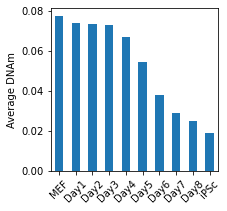

In [25]:
fig, ax = plt.subplots(figsize=(3,3))
pl=hz[['ch']+fs]
pl.columns=['ch','MEF']+['Day'+str(c) for c in list(range(1,9))]+['iPSc']
ax=pl.mean().plot(kind='bar')
ax.tick_params(axis='x', rotation=45)
ax.set(xlabel='',ylabel='Average DNAm');

In [27]:
pl=pl.melt('ch')

In [28]:
pl.head(1)

,ch,variable,value
0,chr8,MEF,0.252289


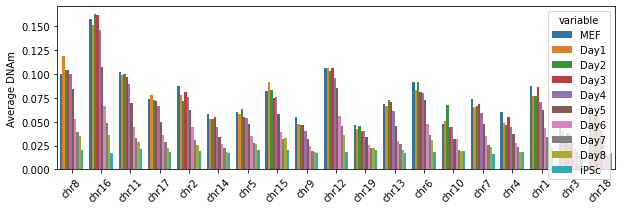

In [30]:
fig, ax = plt.subplots(figsize=(10,3))
ax=sns.barplot(data=pl,x='ch',hue='variable',y='value',ci=0);
ax.set(xlabel='',ylabel='Average DNAm');
ax.tick_params(axis='x', rotation=45)